In [1]:
import numpy as np
import tensorflow as tf
import random
from constants import TASK_LIST
from constants import INITIAL_ALPHA
from constants import INITIAL_GAMMA
from constants import EPSILON
from constants import NUM_TRA_EPISODES_DQN
from constants import NUM_EVAL_EPISODES
from scene_loader import THORDiscreteEnvironment as Environment


np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 512, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            #print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]

        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]

        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylim(0,10)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()





In [2]:
def evaluate(compare_list, env, RL):
    reward_list = []
    episodelength_list = []
    collision_list = []
    for i in range(NUM_EVAL_EPISODES):
        env.reset()
        current_state = env.current_state_id
        observation = env.h5_file['resnet_feature'][current_state][0]
        episode_reward = 0
        episode_length = 0
        episode_collision = 0

        while env.terminal==False:
            action = RL.choose_action(observation)
            env.step(action)
            observation_ =  env.h5_file['resnet_feature'][env.current_state_id][0]
            if env.terminal == True:
                R = 10
            elif env.collided == True:
                R = -0.1
                episode_collision += 1
            else: 
                R = -0.01
            episode_reward += R
            episode_length += 1
            observation = observation_
        reward_list.append(episode_reward)
        episodelength_list.append(episode_length)
        collision_list.append(episode_collision)
    compare_list.append([reward_list, episodelength_list, collision_list])
    #print ("episodes: ", i)

In [ ]:
list_of_tasks = TASK_LIST
scene_scopes = list_of_tasks.keys()


branches = []
for scene in scene_scopes:
    for task in list_of_tasks[scene]:
        branches.append((scene, task))

scene, task = branches[0]


env = Environment({
    'scene_name': scene,
    'terminal_state_id': int(task)
})
env.reset()


RL = DeepQNetwork(env.nA, 2048,
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      # output_graph=True
                      )


step = 0
compare_list=[]
for i in range(1000):
    # initial observation
    env.reset()
    current_state = env.current_state_id
    observation = env.h5_file['resnet_feature'][current_state][0]
    
    episode_reward = 0
    episode_length = 0
        
    while env.terminal==False and episode_length<10000:

        # RL choose action based on observation
        action = RL.choose_action(observation)
        # RL take action and get next observation and reward
        
        env.step(action)
        observation_ =  env.h5_file['resnet_feature'][env.current_state_id][0]
        if env.terminal == True:
            R = 10
        elif env.collided == True:
            R = -0.1
        else: R = -0.01
        episode_length += 1
        episode_reward += R
        RL.store_transition(observation, action, R, observation_)

        if (step > 200) and (step % 5 == 0):
            RL.learn()

        # swap observation
        observation = observation_
        step += 1
    
    print ("episodes: ", i)
    print ("current id: ", env.current_state_id)
    print ("episode reward: ", episode_reward)
    print ("episode length: ", episode_length)
    if (i+1) % 200 == 0:
        evaluate(compare_list, env, RL)
#RL.plot_cost()

In [4]:
RL.plot_cost()

<Figure size 640x480 with 1 Axes>

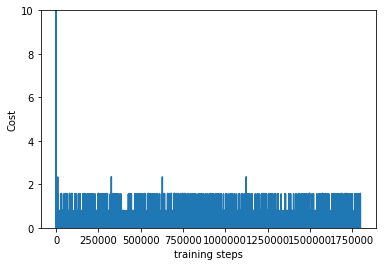

In [5]:
import matplotlib.pyplot as plt
plt.plot(RL.cost_his)
plt.ylim(0,10)
plt.ylabel('Cost')
plt.xlabel('training steps')
plt.show()


In [6]:
len(compare_list)

19

In [8]:
for i in range(19):
    print ("evaluate reward: ", np.mean(np.array(compare_list)[i][0]))

evaluate reward:  -19.10320000000003
evaluate reward:  -22.533700000001367
evaluate reward:  -22.728600000001034
evaluate reward:  -18.569800000000658
evaluate reward:  -58.96659999999918
evaluate reward:  -19.742500000000724
evaluate reward:  -18.79040000000117
evaluate reward:  -20.96000000000171
evaluate reward:  -18.777700000000806
evaluate reward:  -23.11050000000046
evaluate reward:  -19.687500000001275
evaluate reward:  -21.737800000000355
evaluate reward:  -25.92370000000048
evaluate reward:  -11.554100000000322
evaluate reward:  -22.521000000000576
evaluate reward:  -18.651200000000777
evaluate reward:  -21.870700000000603
evaluate reward:  -16.77760000000018
evaluate reward:  -20.452900000000135


In [ ]:
for i in range(10):
    print ("evaluate length: ", np.mean(np.array(compare_list)[i][1]))